In [1]:
# LB Score = 0.83793

# version 1.3
# Added Total damage feature

In [17]:
import statistics as st
from scipy.sparse import hstack
import time
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
import ujson as json
from tqdm import tqdm_notebook

In [3]:
def prepare_submit(model, x_test, file_name = 'submission'):
    y_test_pred= model.predict_proba(X_test)[:, 1]
    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    df_submission.to_csv(file_name)

In [4]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None, silent = False):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        if (not silent) : print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 2000)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:20].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 10));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [5]:
train = pd.read_csv('../data/train_features.csv', index_col='match_id_hash')
target = pd.read_csv('../data/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('../data/test_features.csv', index_col='match_id_hash')

In [6]:
split_index = train.shape[0]

In [7]:
df = pd.concat([train, test], sort=False)

In [8]:
FE = pd.read_csv('FE.csv', index_col='match_id_hash')

In [9]:
df = pd.concat([df, FE], axis = 1, sort = False)

In [10]:
items_damage = pd.read_csv('new_features.csv', index_col='match_id_hash')

In [11]:
df = pd.concat([df, items_damage], axis = 1, sort = False)

In [12]:
new_features = pd.DataFrame()

In [13]:
r_x_min = df[['r1_x', 'r2_x','r3_x','r4_x','r5_x']].min(axis = 1)
r_y_min = df[['r1_y', 'r2_y','r3_y','r4_y','r5_y']].min(axis = 1)
r_x_max = df[['r1_x', 'r2_x','r3_x','r4_x','r5_x']].max(axis = 1)
r_y_max = df[['r1_y', 'r2_y','r3_y','r4_y','r5_y']].max(axis = 1)

In [21]:
new_features['r1_dist'] = np.sqrt((df['r1_y'] - r_y_min)**2 + (df['r1_x'] - r_x_min)**2)
new_features['r2_dist'] = np.sqrt((df['r2_y'] - r_y_min)**2 + (df['r2_x'] - r_x_min)**2)
new_features['r3_dist'] = np.sqrt((df['r3_y'] - r_y_min)**2 + (df['r3_x'] - r_x_min)**2)
new_features['r4_dist'] = np.sqrt((df['r4_y'] - r_y_min)**2 + (df['r4_x'] - r_x_min)**2)
new_features['r5_dist'] = np.sqrt((df['r5_y'] - r_y_min)**2 + (df['r5_x'] - r_x_min)**2)

In [22]:
new_features['r_avg_dist'] = new_features[['r1_dist', 'r2_dist', 'r3_dist', 'r4_dist', 'r5_dist']].mean(axis = 1)

In [23]:
new_features['d1_dist'] = np.sqrt((df['d1_y'] - r_y_max)**2 + (df['d1_x'] - r_x_max)**2)
new_features['d2_dist'] = np.sqrt((df['d2_y'] - r_y_max)**2 + (df['d2_x'] - r_x_max)**2)
new_features['d3_dist'] = np.sqrt((df['d3_y'] - r_y_max)**2 + (df['d3_x'] - r_x_max)**2)
new_features['d4_dist'] = np.sqrt((df['d4_y'] - r_y_max)**2 + (df['d4_x'] - r_x_max)**2)
new_features['d5_dist'] = np.sqrt((df['d5_y'] - r_y_max)**2 + (df['d5_x'] - r_x_max)**2)

In [24]:
new_features['d_avg_dist'] = new_features[['d1_dist', 'd2_dist', 'd3_dist', 'd4_dist', 'd5_dist']].mean(axis = 1)

In [25]:
new_features['dist_prop'] =  new_features['r_avg_dist'] / new_features['d_avg_dist']

In [28]:
new_features = new_features.drop(['r1_dist', 'r2_dist', 'r3_dist','r4_dist','r5_dist', 
              'd1_dist', 'd2_dist', 'd3_dist', 'd4_dist', 'd5_dist'], axis = 1)

In [29]:
df = pd.concat([df, new_features], axis = 1, sort = False)

In [30]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [31]:
df.shape

(49675, 845)

In [32]:
df = df.drop('r1_roshans_killed', axis = 1)
df = df.drop('r2_roshans_killed', axis = 1)
df = df.drop('r3_roshans_killed', axis = 1)
df = df.drop('r4_roshans_killed', axis = 1)
df = df.drop('r5_roshans_killed', axis = 1)

In [33]:
df = df.drop('d1_roshans_killed', axis = 1)
df = df.drop('d2_roshans_killed', axis = 1)
df = df.drop('d3_roshans_killed', axis = 1)
df = df.drop('d4_roshans_killed', axis = 1)
df = df.drop('d5_roshans_killed', axis = 1)

In [34]:
df.shape

(49675, 835)

In [35]:
train = df[:split_index].copy()
test = df[split_index:].copy()

In [36]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d_item_yasha,radiant_tower_kills,dire_tower_kills,diff_tower_kills,r_damage,d_damage,diff_damage,r_avg_dist,d_avg_dist,dist_prop
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0.0,0.0,0.0,948.0,2949.0,-2001.0,69.507308,71.724262,0.969091
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,2.0,0.0,2.0,17463.0,13063.0,4400.0,79.937039,48.190104,1.658785
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,0.0,0.0,70.0,68.0,2.0,68.157552,40.479926,1.683737
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,0.0,0.0,0.0,0.0,15542.0,8337.0,7205.0,71.153249,75.978428,0.936493
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.0,0.0,0.0,0.0,5940.0,11951.0,-6011.0,69.738720,67.839303,1.027999


In [37]:
train['radiant_win'] = target['radiant_win']

Fold 0 started at Sun Oct 13 04:53:53 2019
Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.887607	valid_1's auc: 0.828648
[2000]	training's auc: 0.934768	valid_1's auc: 0.831497
[3000]	training's auc: 0.964999	valid_1's auc: 0.832089
[4000]	training's auc: 0.983301	valid_1's auc: 0.832354
[5000]	training's auc: 0.993346	valid_1's auc: 0.832142
Early stopping, best iteration is:
[3830]	training's auc: 0.980917	valid_1's auc: 0.832412
Fold 1 started at Sun Oct 13 04:54:23 2019
Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.889797	valid_1's auc: 0.81681
[2000]	training's auc: 0.935968	valid_1's auc: 0.820576
[3000]	training's auc: 0.965818	valid_1's auc: 0.821842
[4000]	training's auc: 0.983883	valid_1's auc: 0.82276
[5000]	training's auc: 0.993435	valid_1's auc: 0.822784
[6000]	training's auc: 0.997811	valid_1's auc: 0.822954
[7000]	training's auc: 0.999447	valid_1's auc: 0.823158
[8000]	training's auc: 0.99

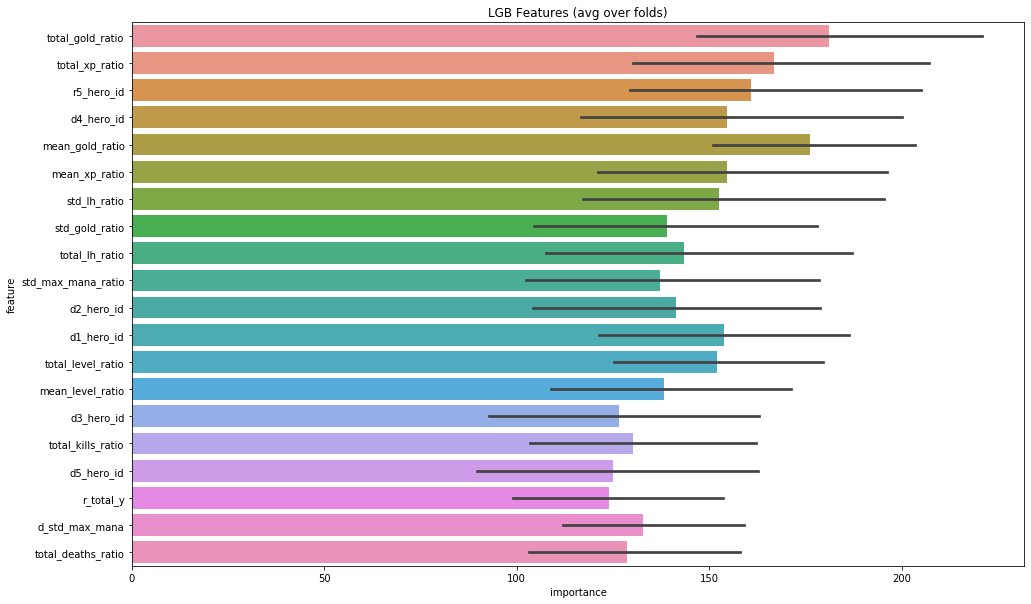

In [38]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = target['radiant_win']
X_test = test.reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True, silent = False)

In [39]:
prediction_lgb

array([0.56355204, 0.99594015, 0.97438665, ..., 0.17502948, 0.22340102,
       0.0769308 ])

In [40]:
df_submission = pd.DataFrame({'radiant_win_prob': prediction_lgb}, 
                                 index=test.index)
df_submission.to_csv('Submission6_EF_items_damage_coords.csv')

In [ ]:
# CV mean score: 0.8290, std: 0.0049

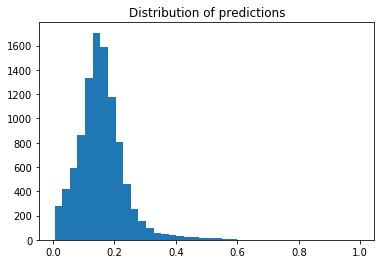

In [41]:
plt.hist(prediction_lgb, bins=40);
plt.title('Distribution of predictions');